## In this code file, I made the encoding/merging/other code cells reusable. They will receive a data frame titled either df_oh (one-hot encoded), df_under500_deluxe (Airbnb data paired with Niche data), or df_under500_inc (incomplete; some more of the data was removed). Variable names like these can be overwritten with data frames generated with different criteria.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # another visualization library, does correlation matrix
import sklearn
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
import pydotplus # to print the tree
from IPython.display import Image
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.svm import SVR
import keras
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.metrics import mean_absolute_percentage_error # why didn't this work?

ImportError: cannot import name 'mean_absolute_percentage_error' from 'sklearn.metrics' (/Users/ryanburczak/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [6]:
sklearn.__version__ # oh, yeah... version 0.24 is not supported by Jupyter Notebook

'0.23.2'

## generate df_nonames

In [7]:
df = pd.read_csv("NewYork_Airbnb.csv") # load in the original data
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [72]:
df.info() # gives the metadata... you can see there are 48,895 instances

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## are there any duplicates?

In [8]:
df["id"].nunique()
# The number of unique Airbnb ID numbers is 48,895 (same as total number of Airbnbs). So, no duplicates!

48895

## just for fun, try typing a name in here and seeing how many Airbnbs have a host with that name! :)

In [20]:
name = "Ryan"
print(sum(df["host_name"] == name))
df[df["host_name"] == name]

108


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
599,226021,Sunny 2 bedroom Williamsburg Duplex w/ 3 beds,815977,Ryan,Brooklyn,Williamsburg,40.71126,-73.94576,Entire home/apt,220,3,116,2019-06-30,1.23,2,135
1100,466277,"W'burg 2 bedroom w/ yard & laundry, 5 mins to L",815977,Ryan,Brooklyn,Williamsburg,40.71110,-73.94643,Entire home/apt,235,3,108,2019-07-02,1.25,2,144
1433,644464,Loft Room in Heart of Williamsburg,3225114,Ryan,Brooklyn,Williamsburg,40.71827,-73.96259,Private room,350,2,3,2012-09-23,0.04,1,365
2437,1215836,Prospect Park Apt,6533489,Ryan,Brooklyn,Crown Heights,40.67394,-73.95951,Entire home/apt,150,2,1,2017-06-22,0.04,1,0
2460,1238285,Stuyvesant Heights Apt mins 2 City,6270968,Ryan,Brooklyn,Bedford-Stuyvesant,40.68185,-73.94108,Private room,59,3,13,2017-08-18,0.26,2,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43755,33850661,Amazing private room 5 min time square,45578040,Ryan,Manhattan,Hell's Kitchen,40.76921,-73.99239,Private room,105,1,1,2019-04-18,0.37,2,0
43871,33915820,Manhattan Ave Apartment 2 stops from Times Square,18416970,Ryan,Manhattan,Harlem,40.80712,-73.95686,Private room,103,2,14,2019-07-07,5.83,1,19
47290,35677001,Large Times Sq/Midtown/Broadway Luxury High-rise,11908795,Ryan,Manhattan,Hell's Kitchen,40.76150,-73.99546,Entire home/apt,350,5,0,NaN,NaN,1,87
47364,35708459,ROOM 1,6270968,Ryan,Brooklyn,Bedford-Stuyvesant,40.68364,-73.94067,Private room,43,3,0,NaN,NaN,2,320


## data cleaning

In [22]:
# Drop useless columns
df_nonames = df.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1)

# Fill in missing reviews-per-month values with the mean of the non-missing values from the same column
df_nonames["reviews_per_month"] = df_nonames["reviews_per_month"].fillna(np.mean(df_nonames["reviews_per_month"]))
df_nonames.dropna(inplace = True) # inplace so you don't have to declare a new variable

df_nonames.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0


# get df_under500

In [23]:
# Histogram with $500 and less
df_under500 = df_nonames[(df_nonames["price"] <= 500) & (df_nonames["price"] > 25)]
# also filtering out the Airbnbs $25 and under; there are only 218 of those
df_under500

## just out of curiosity, how would things be different if we tried the log_price instead? (this code cell is just for trial!!!!)

In [24]:
df_under500_logprice = df_under500.copy() # make a copy
df_under500_logprice["price"] = np.log10(df_under500_logprice["price"])
# DISCLAIMER: I would call the new feature log_price, but then I would have to change "price" to
# "log_price" in every function later on in this file. So, for convenience, I gave the new copy
# of df_under500 a name that indicates it has log-prices, not the original prices.
df_under500_logprice

# Analyze the distributions of the other features

In [158]:
# We're removing Staten Island, because doing so is known to improve the model's performance
# After all, doesn't Staten Island look more like it belongs to New Jersey than New York?
df_under500_new = df_under500[df_under500["neighbourhood_group"] != "Staten Island"]

# RUN THIS CODE TO RESET IF NEEDED

In [57]:
# Let's view the distributions of...
# minimum_nights (1 to 1250 nights)
# number_of_reviews (0 to 629)
# reviews_per_month (0.01 to 58.5)
# availability_365 (0 to 365)
df_under500_new.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,47260.000000,47260.000000,47260.000000,47260.000000,47260.000000,47260.000000,47260.000000,47260.000000
mean,40.729828,-73.950594,132.370842,6.998159,23.525836,1.373035,7.129518,110.497588
std,0.053787,0.044198,88.029565,20.381515,44.880598,1.505650,32.955905,130.726064
min,40.565460,-74.039420,26.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690607,-73.982250,69.000000,1.000000,1.000000,0.270000,1.000000,0.000000
50%,40.723210,-73.955020,105.000000,3.000000,5.000000,1.200000,1.000000,41.000000
75%,40.763542,-73.935460,175.000000,5.000000,24.000000,1.592500,2.000000,220.000000
max,40.913060,-73.712990,500.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## check the percentiles

In [83]:
df_under500_new["availability_365"].quantile(0.50) # holy cow, 45 is at the 99th percentile!
len(df_under500_new[df_under500_new["availability_365"] == 0]) # 17204 with no availability?!?

17204

## lop off the outliers!

In [159]:
df_under500_new = df_under500_new[df_under500_new["minimum_nights"] <= 200]
df_under500_new = df_under500_new[df_under500_new["number_of_reviews"] <= 350]
df_under500_new = df_under500_new[df_under500_new["reviews_per_month"] <= 10]

In [25]:
df_under500_new

In [162]:
# just for consistency...
df_under500_inc = df_under500_new.copy()

# Try keeping only Manhattan and Brooklyn

In [116]:
len(df_under500[(df_under500["neighbourhood_group"] == "Manhattan") | (df_under500["neighbourhood_group"] == "Brooklyn")])

40604

In [26]:
df_under500_inc = df_under500[(df_under500["neighbourhood_group"] == "Manhattan") | (df_under500["neighbourhood_group"] == "Brooklyn")]
df_under500_inc # because it's an incomplete set

# Try removing Staten Island (best choice)

In [5]:
len(df_under500[df_under500["neighbourhood_group"] == "Staten Island"])

362

### if you're using df_under500 (Recommended)

In [27]:
df_under500_inc = df_under500[df_under500["neighbourhood_group"] != "Staten Island"]
df_under500_inc # because it's an incomplete set

### if you're using df_under500_logprice

In [28]:
df_under500_inc = df_under500_logprice[df_under500_logprice["neighbourhood_group"] != "Staten Island"]
df_under500_inc # because it's an incomplete set

## also remove shared rooms (only 2% of the data)... maybe don't do this

In [103]:
len(df_under500_inc[df_under500_inc["room_type"] == "Shared room"])
# there are only 1034 shared rooms not on Staten Island

1034

In [104]:
df_under500_inc = df_under500_inc[df_under500_inc["room_type"] != "Shared room"]
df_under500_inc

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48889,Queens,Jamaica,40.69137,-73.80844,Private room,65,1,0,1.373221,2,163
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,1.373221,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,1.373221,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1.373221,1,27


# Try removing Staten Island and Queens

In [73]:
len(df_under500[(df_under500["neighbourhood_group"] == "Staten Island") | (df_under500["neighbourhood_group"] == "Queens")])

5955

In [29]:
df_under500_inc = df_under500[(df_under500["neighbourhood_group"] != "Staten Island") & (df_under500["neighbourhood_group"] != "Queens")]
df_under500_inc # because it's an incomplete set

# Try limiting the data set to the top 12 neighborhoods for touring

### Midtown, Upper West Side, Upper East Side, Tribeca, SoHo, East Village, Greenwich Village, Chelsea, Financial District, Lower East Side, Chinatown, Little Italy

In [10]:
len(df_under500[df_under500["neighbourhood"].isin(["Midtown", "Upper West Side", "Upper East Side",
                                                    "Tribeca", "SoHo", "East Village", "Greenwich Village",
                                                    "Chelsea", "Financial District", "Lower East Side",
                                                    "Chinatown", "Little Italy"])])
                


10824

In [33]:
df_under500_inc = df_under500[df_under500["neighbourhood"].isin(["Midtown", "Upper West Side", "Upper East Side",
                                                    "Tribeca", "SoHo", "East Village", "Greenwich Village",
                                                    "Chelsea", "Financial District", "Lower East Side",
                                                    "Chinatown", "Little Italy"])]


df_under500_inc

### so, apparently all these neighborhoods are in Manhattan!

In [13]:
df_under500_inc["neighbourhood_group"].unique()

array(['Manhattan'], dtype=object)

# ONE-HOT ENCODING df_under500_inc (without Niche data)

In [34]:
# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500_inc["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500_inc["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500_inc["room_type"], prefix = "room_type")
df_under500_inc.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500_inc]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh

In [ ]:
df_oh

# merge with Niche data (once you obtain it!!!)

### then go encode this df_under500_deluxe variant; scroll down to find it

In [35]:
df_under500_deluxe = df_under500_inc.merge(niche_data, how = 'inner', left_on = "neighbourhood",
                                       right_on = "Airbnb Neighborhood")
df_under500_deluxe.drop("Airbnb Neighborhood", axis = 1, inplace = True)
# df_under500_deluxe = df_under500_deluxe[df_under500_deluxe["Overall Grade Niche"] != "C-"]
# Drop Airbnbs in neighborhoods rated C- by Niche
df_under500_deluxe.head()

# Standard Scaler and Splitting

In [12]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = StandardScaler()
X = scaler.fit_transform(X_beforescaling)

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape) # varies based on version of data passed in
print(X_test.shape) # varies based on version of data passed in

(33300, 189)
(11101, 189)


# Random Forest Regressor (best performer; 200 trees)

In [11]:
# Random forest
rfr = RandomForestRegressor(n_estimators = 200) # default is 100
rfr = rfr.fit(X_train, y_train) # need to get X_train and y_train from directly above first

In [97]:
print("Number of trees in forest is", len([estimator.get_depth() for estimator in rfr.estimators_]))

Number of trees in forest is 200


In [13]:
predictions = rfr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mae

# With 100 trees:
# Random forest with original 10 features, without Staten Island, with prices $25 < x <= $500, mae = 39.89
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, mae = 39.45 (better)

# With 200 trees:
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, mae = 39.22

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse


# rmse = 61.081503595648364 with df_under500_deluxe, standard scaling, random forest

# UPDATE 3/28/21: rmse = 60.32 with random forest on original 10 features plus Niche rent price
# and C- airbnbs removed

# With 100 trees
# Random forest with original 10 features, without Staten Island, with prices $25 < x <= $500, rmse = 60.60
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, rmse = 60.01 (better)

# With 200 trees
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, rmse = 59.71

In [16]:
explained_variance_score(y_test, predictions)

# With 100 trees:
# Random forest with original 10 features, without Staten Island, with prices $25 < x <= $500, exp-var = 0.521
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, exp-var = 0.532

# With 200 trees:
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, exp-var = 0.536

In [15]:
# this gives the mean absolute percentage error
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(predictions)))) * 100

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python

# With 200 trees:
# Random forest with 10 + Niche rent, without Staten Island, with prices $25 < x <= $500, MAPE = 32.41%

# Feedforward Neural Network

## construct the FNN here (add_layers)

In [14]:
def add_layers():
    reg = Sequential()
    reg.add( Dense(units = 128, kernel_initializer = "uniform", activation = "relu", input_dim = 191) )
    # adds a layer to the neural network
    # layers of size 32
    # ReLu (Rectified Linear Unit) acts like neurons, outputting values at full potential
    # the one-hot encoded df_under500 has 235 columns!
    
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    # Dropout is used for regularization, to ensure the model doesn't overfit, or over-learn
    
    reg.add( Dense(units = 64,  activation = "relu") ) # this adds a second dense layer
    #reg.add( Activation("relu") )
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    
    reg.add( Dense(units = 32,  activation = "relu") ) # this adds a third dense layer
    reg.add( Dense(units = 16,  activation = "relu") ) # this adds a fourth dense layer
    reg.add( Dense(units = 8,  activation = "relu") ) # this adds a fourth dense layer
    
    
    reg.add( Dense(units = 1) ) # this adds the output layer (prediction)
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    reg.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])
    # this compile statement is necessary for neural networks
    # Adam is a replacement optimization algorithm for stochastic gradient descent
    # for training deep learning models.
    
    return reg

### cross-validation

In [1]:
krg = KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125)
# the data will be processed 50 lines (instances) at a time
# epochs is how many times you want the model to "learn" (and update its estimates)
score = cross_val_score(krg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 2)

# cross-validation, no fitting

In [56]:
score

array([-4265.78235394, -7967.50253973])

### fitting

In [9]:
hist = krg.fit(X_train, y_train, epochs = 125) # fitting, takes about 2 minutes

### results

In [12]:
y_pred = krg.predict(X_test) # predictions
print(y_test)
print(y_pred)

In [11]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))
r2 = r2_score(y_test, np.rint(y_pred).astype('int32'))
print("R^2 score =", r2)

In [10]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(y_pred)))) * 100
# this gives the mean absolute percentage error

## 33.66% with df_under500_deluxe

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python

# Data from Niche

In [6]:
niche_data = pd.read_csv("NYC_Niche.csv")

In [66]:
niche_data[niche_data["Overall Grade Niche"] == "C-"]

,Airbnb Neighborhood,Median Rent Price Niche,Median Home Price Niche,Overall Grade Niche
206,West Farms,1054,392066,C-


# encoding df_under500_deluxe

In [6]:
# The neighborhood, borough, and room type will be one-hot encoded

# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500_deluxe["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500_deluxe["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500_deluxe["room_type"], prefix = "room_type")
df_under500_deluxe.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500_deluxe]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
df_oh

## creating a dictionary for the letter grades

In [9]:
# grade_score = {"A+": 2, "A": 2, "A-": 2, "B+": 1, "B": 1, "B-": 1, "C+": 0, "C": 0, "C-": 0}
grade_score = {"A+": 8, "A": 7, "A-": 6, "B+": 5, "B": 4, "B-": 3, "C+": 2, "C": 1, "C-": 0}
df_oh["Overall Grade Niche"] = df_oh["Overall Grade Niche"].replace(grade_score)

In [7]:
# df_oh

## do we want to drop any features?

In [45]:
df_oh.drop(["Median Rent Price Niche"], axis = 1, inplace = True)

In [10]:
df_oh.drop(["Median Home Price Niche"], axis = 1, inplace = True)

In [11]:
df_oh.drop(["Overall Grade Niche"], axis = 1, inplace = True)

In [3]:
# list(df_oh.columns)

# Make plots to display data

## 4 sideways bar plots to show each metric for the two best models.

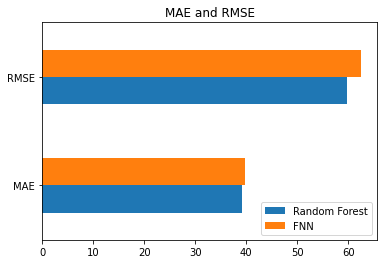

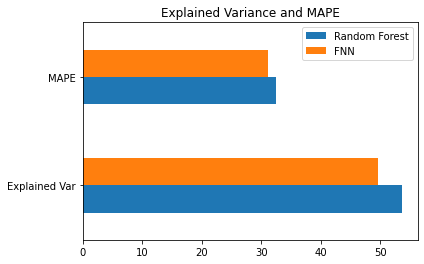

In [72]:
errors_dict = {"Random Forest": [39.22, 59.71], "FNN": [39.69, 62.53]}
pct_errors_dict = {"Random Forest": [53.6, 32.41], "FNN": [49.7, 31.13]}

# fig, ax = plt.subplots(1,2)
errors_df = pd.DataFrame(errors_dict, columns = ["Random Forest", "FNN"], index = ["MAE", "RMSE"])
errors_df.plot.barh()
plt.title("MAE and RMSE")
plt.show()
plt.save("BestModels_MAE+RMSE")

pct_errors_df = pd.DataFrame(pct_errors_dict, columns = ["Random Forest", "FNN"], index = ["Explained Var", "MAPE"])
pct_errors_df.plot.barh()
plt.title("Explained Variance and MAPE")
plt.show()
plt.save("BestModels_EVS+MAPE")

# source: https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.add_subplot


# Learning curves (training vs validation curves) for the two best models

## Random Forest Regressor, RMSE

In [14]:
%%time
# for Random Forest Regressor
size, train_scores, valid_scores = learning_curve(RandomForestRegressor(n_estimators = 200), X,y, train_sizes = [1,1000,5000,10000,20000,35000], cv = 5, scoring = 'neg_mean_squared_error')



CPU times: user 8min 52s, sys: 3.44 s, total: 8min 55s
Wall time: 8min 56s


In [23]:
np.sqrt(abs(train_scores))

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [17.42837697, 29.94703961, 30.10666841, 29.70602146, 29.96654382],
       [24.87065598, 24.08679823, 24.025608  , 23.84422435, 23.96859378],
       [24.77883281, 23.06524722, 21.82821611, 21.86288023, 21.86444733],
       [23.18894343, 22.25351508, 23.135556  , 23.43378913, 23.41209091],
       [22.41398569, 21.95028167, 22.50783922, 22.29830574, 22.65407372]])

### show graph for mean of all 5 cross-vals

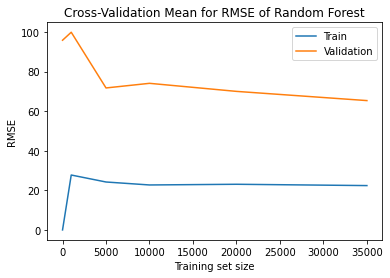

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(size, np.sqrt(-train_scores.mean(axis = 1)), label = "Train")
plt.plot(size, np.sqrt(-valid_scores.mean(axis = 1)), label = "Validation")
plt.title("Cross-Validation Mean for RMSE of Random Forest")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend()
plt.show()
plt.savefig("RandomForestRMSE_mean.png")

## Random Forest Regressor, MAE

In [16]:
%%time
# for Random Forest Regressor
size, train_scores, valid_scores = learning_curve(RandomForestRegressor(n_estimators = 200), X, y, train_sizes = [1,1000,5000,10000,20000,35000], cv = 5, scoring = 'neg_mean_absolute_error')


CPU times: user 8min 53s, sys: 3.45 s, total: 8min 56s
Wall time: 8min 57s


### show graph for mean of all 5 cross-vals

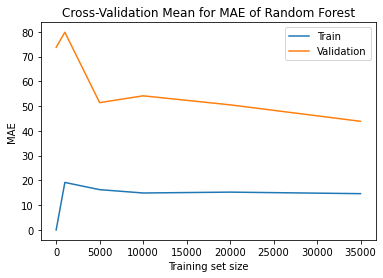

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(size, (-train_scores.mean(axis = 1)), label = "Train")
plt.plot(size, (-valid_scores.mean(axis = 1)), label = "Validation")
plt.title("Cross-Validation Mean for MAE of Random Forest")
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.legend()
plt.show()
plt.savefig("RandomForestMAE_mean.png")

## Neural Network, MAE (need to run add_layers first!!!)

In [4]:
%%time
# for Neural Network
size, train_scores, valid_scores = learning_curve(KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125), X, y, train_sizes = [50,1000,5000,10000,20000,35000], cv = 5, scoring = 'neg_mean_absolute_error')



### show graph for mean of all 5 cross-vals

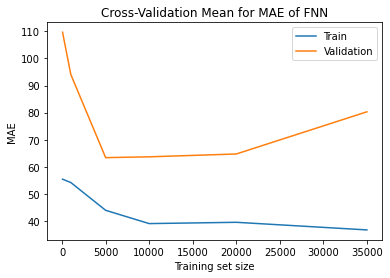

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(size, (-train_scores.mean(axis = 1)), label = "Train")
plt.plot(size, (-valid_scores.mean(axis = 1)), label = "Validation")
plt.title("Cross-Validation Mean for MAE of FNN")
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.legend()
plt.show()
plt.savefig("FNN_MAE_mean.png")

In [5]:
# for Random Forest Regressor
size, train_scores, valid_scores = learning_curve(KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125), X, y, train_sizes = [100,1000,5000,10000,20000,35000], cv = 5, scoring = 'neg_mean_absolute_error')


## Neural Network, RMSE (need to run add_layers first!!!)

In [8]:
%%time
# for Neural Network
size, train_scores, valid_scores = learning_curve(KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125), X, y, train_sizes = [50,1000,5000,10000,20000,35000], cv = 5, scoring = 'neg_mean_squared_error')


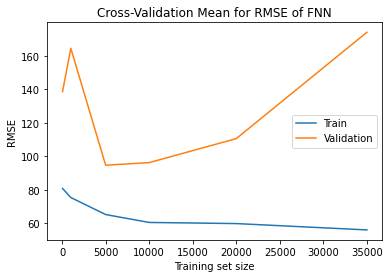

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(size, np.sqrt(-train_scores.mean(axis = 1)), label = "Train")
plt.plot(size, np.sqrt(-valid_scores.mean(axis = 1)), label = "Validation")
plt.title("Cross-Validation Mean for RMSE of FNN")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend()
plt.show()
plt.savefig("FNN_RMSE_mean.png")